In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

# Quiet setting warnings
pd.options.mode.chained_assignment = None

#StratifiedKFold
#n_folds
#Every fold needs to have unchanged data go in - fit scalar on training; apply to training and test
#fit -> transform
#How does fold size effect ROC curve?
#MinMax - need uniform distribution

# Background

In [184]:
# Set wkdir
WORK_DIR = os.getcwd()

In [191]:
# 50 sample data set
data50_df = pd.read_excel(f'{WORK_DIR}/CardiacHypertrophyData_50Samples.xlsx')
print(data50_df.shape)
data50_df.head(5)

(50, 7)


,Age,Sex,Racial group,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Pathologic?
0,59.053851,Male,Asian,0.625929,71.025200,98.960236,0
1,56.291312,Male,White,0.632001,51.666039,112.938934,0
2,66.216488,Male,White,0.601147,105.635574,98.363388,1
3,45.684119,Female,Black or African American,0.546039,96.767563,104.544754,0
4,69.492794,Female,White,0.677071,86.660133,129.907806,1


In [192]:
# 200 sample data set
data200_df = pd.read_excel(f'{WORK_DIR}/CardiacHypertrophyData_200Samples.xlsx')
print(data200_df.shape)
data200_df.head(5)

(200, 7)


,Age,Sex,Racial group,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Pathologic?
0,58.706430,Male,White,0.581767,109.255325,120.983421,0
1,59.108509,Female,Hispanic or Latino,0.706900,104.015976,111.671471,0
2,48.160970,Male,White,0.644444,101.856407,95.749603,0
3,57.649055,Female,Black or African American,0.572398,69.098885,103.728004,0
4,58.849777,Male,White,0.616101,72.875412,104.763771,0


# Generic Functions

In [182]:
def X_y_split(df, target, to_numpy: bool):
    '''
    Function to split df into features (X) and target (y)
    to_numpy boolean flag can be used to convert X and y outputs to numpy arrays
    '''
    X = df.loc[:, df.columns != target]
    y = df.loc[:, target]
    if to_numpy:
        return X.to_numpy(), y.to_numpy()
    else:
        return X, y
    

# EDA

## Missing Data
No missing data in this data set

In [180]:
# View missing data for 50 sample set
print('50 Sample Missing Data:')
print(data50_df.isnull().sum())
print('\n')

# View missing data for 200 sample set
print('200 Sample Missing Data:')
print(data200_df.isnull().sum())

50 Sample Missing Data:
Age                        0
Sex                        0
Racial group               0
Ejection fraction          0
Heart rate (bpm)           0
Systolic blood pressure    0
Pathologic?                0
dtype: int64


200 Sample Missing Data:
Age                        0
Sex                        0
Racial group               0
Ejection fraction          0
Heart rate (bpm)           0
Systolic blood pressure    0
Pathologic?                0
dtype: int64


## Visualizing Target & Feature Balance/Distributions

In [4]:
def num_feature_dist_plot(df, n_col, bins, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(numeric_features):
        
        # Plot
        sns.histplot(data=df, x=feature, ax=plots[i], color='tab:blue', bins=bins)
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        
    plt.show()
        

def cat_feature_count_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each categorical feature in a data frame
    '''

    # Extract features to plot - only non-numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    nonnumeric_features = [feature for feature in X.columns if feature not in numeric_features]
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(nonnumeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(nonnumeric_features):
        
        # Set count df for plot
        labels = list(set(X[feature]))
        counts = [list(X[feature]).count(c) for c in labels]
        plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                                'counts': counts})
        
        
        # Plot
        sns.barplot(data=plot_df, y="labels", x="counts", ax=plots[i], color="tab:blue")
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_ylabel('')
        
    plt.show()
    
    

## Feature Visualization

In [183]:
# Split data for visualizations
X, y = X_y_split(df=data50_df, target='Pathologic?', to_numpy=False)

### Numeric Features

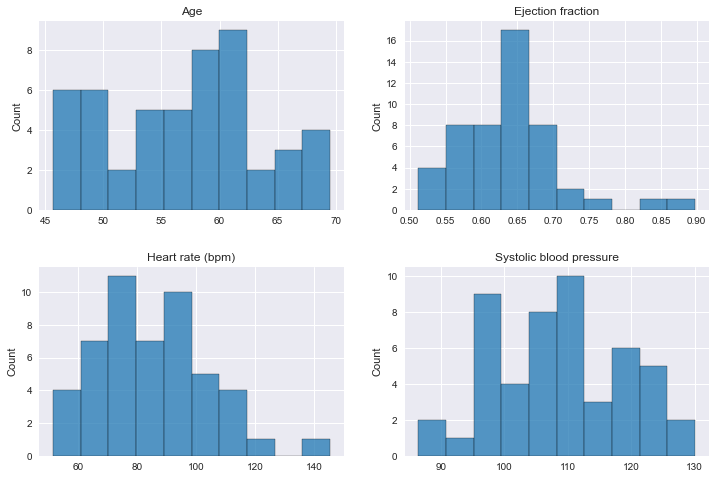

In [7]:
num_feature_dist_plot(df=X, n_col=2, fig_width=12, fig_height=8, bins=10, hspace=0.3, wspace=0.2)

### Categorical Features

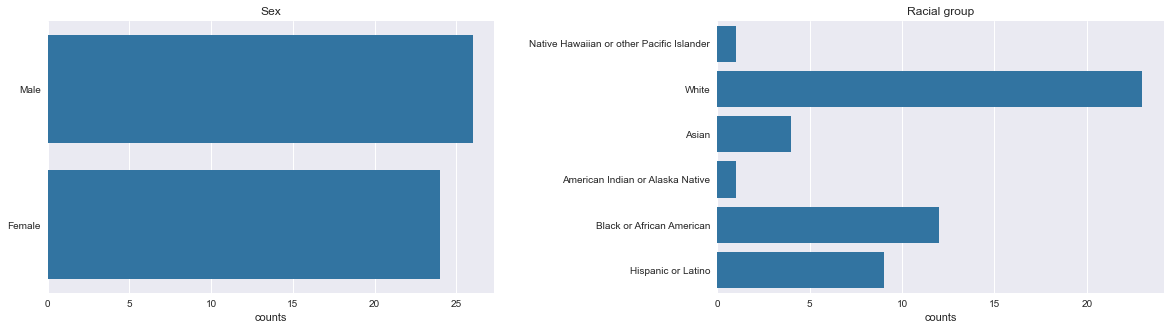

In [8]:
cat_feature_count_plot(df=X, n_col=2, fig_width=20, fig_height=5, hspace=0, wspace=0.5)

## Outcome Visualization

Text(0, 0.5, '')

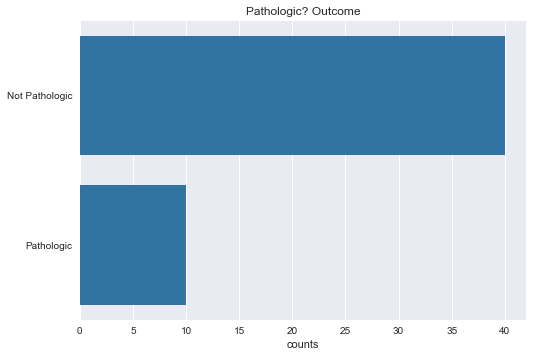

In [9]:
# Encode outcome var
yVis = y.copy()
yVis = yVis.map({0: 'Not Pathologic', 1: 'Pathologic'})

# Set count df for plot
labels = list(set(yVis))
counts = [list(yVis).count(c) for c in labels]
plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                        'counts': counts})    
        
# Plot
fig, ax = plt.subplots()
sns.barplot(data=plot_df, y="labels", x="counts", color="tab:blue")
ax.set_title('Pathologic? Outcome', fontsize=12)
ax.set_ylabel('')

# Data Pre-Processing

## Categorical Variable Encoding

In [157]:
def encodeCategories(X):
    '''
    Function to encode categorical features
    Features with two categories will be encoded as binary
    Features with more than two categories will be one-hot-encoded
    '''
    # Copy df 
    df = X.copy()
    categorialColumnNames_list = df.select_dtypes(include=['object']).columns.values.tolist()
    featureCategoryCount_dict = {feature: len(set(df[feature])) for feature in categorialColumnNames_list}
    
    # Display message
    print('Encoding categorical features...\n')
    
    # Encode feature based on number of categories
    for feature, categoryCount in featureCategoryCount_dict.items():

        # Convert binary feature to binary 0, 1
        if categoryCount == 2:

            # Encode column
            feat0, feat1 = tuple(set(df[feature]))
            df[feature] = df[feature].map({feat0: 0, feat1: 1})

            # Display which category is encoded 0 and 1
            print(feature + ' encoded as binary')
            print(f'   0: {feat0}')
            print(f'   1: {feat1}\n')

        # One-hot-encode feature with more than 2 categories
        elif categoryCount > 2:

            # Code adapted from Antonio Perez, PhD
            # Encode column
            encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
            encoder.fit(df[feature].to_numpy().reshape(-1, 1))
            encodedData = encoder.transform(df[feature].to_numpy().reshape(-1, 1))

            # Copy to data frame
            for i in range(encodedData.shape[1]):
                if type(encoder.categories_[0][i]) == str:
                    df[f'{feature}_{encoder.categories_[0][i]}'] = encodedData[:, i]

            # Drop original column
            df.pop(feature)

            # Display message
            print(f'{feature} one-hot-encoded\n')

        # Safe gaurd against features with only one category
        else:
            pass
        
    return df



# Logistic Regression & Cross-Validation

**Notes on Stratified K-Fold Cross Validation**  
Stratified K-Fold provides train/test indices to split data into train/test sets. Folds are made by preserving the percentage of samples for each class. The number of folds (k) made is controlled by the n_splits parameter. Increasing k decreases the test set size, and vice versa.

## Functions for Implementation

In [241]:
def flatten_list(list_of_lists):
    '''
    Function to flatten a list of lists into one list
    e.g. [[1, 0, 0], [0, 0, 1]] -> [1, 0, 0, 0, 0, 1]
    Source: https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    '''
    return [item for sublist in list_of_lists for item in sublist]


def kFold_logReg_classification(X, y, k_fold: int):
    '''
    Function to implement k-fold cross-validation for Logistic Regression Classification
    
    Inputs: 
        X: Features (numpy matrix)
        y: Target (numpy array)
        k_fold (number of splits for stratified k-fold cross-validator)
        
    Outputs:
    *NOTE: All outputs are concatenated lists that contain results from all folds*
        y_true: True values of targets
        y_pred: Predicted values of targets (as determined by trained Logistic Regression model)
        y_score: Target scores (probability estimates of the positive class)
    '''
    
    # Initialize stratified k-fold cross-validator
    kfold = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=1)
    
    # Store train/test split sizes for each fold size
    fold_info = ''
    
    # Initialize list to store results
    y_true_allFolds = []
    y_pred_allFolds = []
    y_score_allFolds = []

    # For each fold (#folds = k): train, test, evaluate performance
    for train_index, test_index in kfold.split(X, y):

        # Display train/test split size
        fold_info = f'n_kFold: {k_fold}, n_Train: {len(train_index)}, n_Test: {len(test_index)}\n'

        # Split data into train/test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardize features - train scalar on test set to prevent test set leak
        scaler = StandardScaler()               # Initialize scaler
        X_train = scaler.fit_transform(X_train) # Train scalar on training set and tranform training set
        X_test = scaler.transform(X_test)       # Transform test set

        # Train logistic regression model
        logisticReg = LogisticRegression()
        logisticReg.fit(X_train, y_train)

        # Make predictions on test set
        y_pred = logisticReg.predict(X_test)
        y_score = logisticReg.predict_proba(X_test)[:,1]

        # Append results from all folds into collective lists
        y_true_allFolds.append(list(y_test))
        y_pred_allFolds.append(list(y_pred))
        y_score_allFolds.append(list(y_score))
    
    # Flatten lists to evaluate all folds collectively
    y_true_allFoldsFlat = np.array(flatten_list(y_true_allFolds))
    y_pred_allFoldsFlat = np.array(flatten_list(y_pred_allFolds))
    y_score_allFoldsFlat = np.array(flatten_list(y_score_allFolds))
    
    # Provide fold information (n_kFold, n_Train, n_Test)
    print('Stratified k-fold cross-validation information')
    print(fold_info + '\n')
    
    # Return lists
    return y_true_allFoldsFlat, y_pred_allFoldsFlat, y_score_allFoldsFlat


def logReg_performance_eval(y_true, y_pred, y_score, roc_label):
    '''
    Function to evaluate performance of Logistic Regression (or any binary) classifier
    
    Inputs:
        y_true: True values of targets
        y_pred: Predicted values of targets (as determined by trained model)
        y_score: Target scores (probability estimates of the positive class)
        
    Outputs:
        Classification report
        ROC curve with AUC score reported
    '''
    
    # Performance evaluation
    print(classification_report(y_true, y_pred))

    # ROC & AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)    
    
    # ROC Curve
    #plt.figure()
    plt.plot(fpr, tpr, marker='.', label=f'{roc_label} (AUC = %0.2f)' % auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    #plt.show()
    
    

## 50 Sample Data Set

Encoding categorical features...

Sex encoded as binary
   0: Male
   1: Female

Racial group one-hot-encoded

-----------------------------------------------

Stratified k-fold cross-validation information
n_kFold: 2, n_Train: 25, n_Test: 25


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        40
           1       1.00      0.40      0.57        10

    accuracy                           0.88        50
   macro avg       0.93      0.70      0.75        50
weighted avg       0.90      0.88      0.86        50

------------------------------------------------------------

Stratified k-fold cross-validation information
n_kFold: 5, n_Train: 40, n_Test: 10


              precision    recall  f1-score   support

           0       0.86      0.95      0.90        40
           1       0.67      0.40      0.50        10

    accuracy                           0.84        50
   macro avg       0.77      0.68      0.70        50
weighted 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=20.
  warnings.warn(("The least populated class in y has only %d"


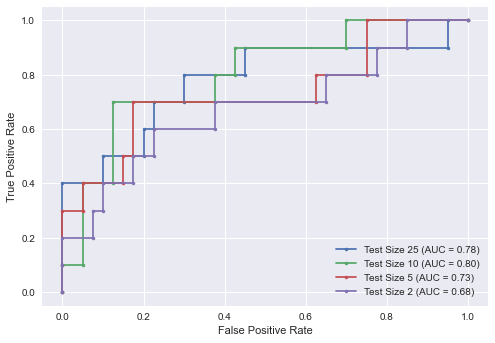

In [243]:
# Split into X, y and encode categorical features
# 50/50, 60/40, 70/30, 80/20, 90/10

X, y = X_y_split(df=data50_df, target='Pathologic?', to_numpy=False)
X = encodeCategories(X)
print(f'-----------------------------------------------\n')

# Implement k-fold cross-validation with logistic regression classifier for multiple sizes of k
k_sizes = [2, 5, 10, 20]
for k in k_sizes:
    
    # Stratified k-fold cross-validation of Logistic Regression model
    y_true, y_pred, y_score = kFold_logReg_classification(X=X.to_numpy(), y=y.to_numpy(), k_fold=k)
    
    # Evaluate performance
    logReg_performance_eval(y_true=y_true, y_pred=y_pred, y_score=y_score, roc_label=f'Test Size {int(50/k)}')
    print(f'------------------------------------------------------------\n')
    

## 200 Sample Data Set

Encoding categorical features...

Sex encoded as binary
   0: Male
   1: Female

Racial group one-hot-encoded

-----------------------------------------------

Stratified k-fold cross-validation information
n_kFold: 2, n_Train: 100, n_Test: 100


              precision    recall  f1-score   support

           0       0.85      0.96      0.90       160
           1       0.65      0.33      0.43        40

    accuracy                           0.83       200
   macro avg       0.75      0.64      0.67       200
weighted avg       0.81      0.83      0.81       200

------------------------------------------------------------

Stratified k-fold cross-validation information
n_kFold: 4, n_Train: 150, n_Test: 50


              precision    recall  f1-score   support

           0       0.85      0.95      0.90       160
           1       0.62      0.33      0.43        40

    accuracy                           0.82       200
   macro avg       0.73      0.64      0.66       200
weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 40 members, which is less than n_splits=100.
  warnings.warn(("The least populated class in y has only %d"


Stratified k-fold cross-validation information
n_kFold: 100, n_Train: 198, n_Test: 2


              precision    recall  f1-score   support

           0       0.85      0.93      0.89       160
           1       0.56      0.35      0.43        40

    accuracy                           0.81       200
   macro avg       0.71      0.64      0.66       200
weighted avg       0.79      0.81      0.80       200

------------------------------------------------------------



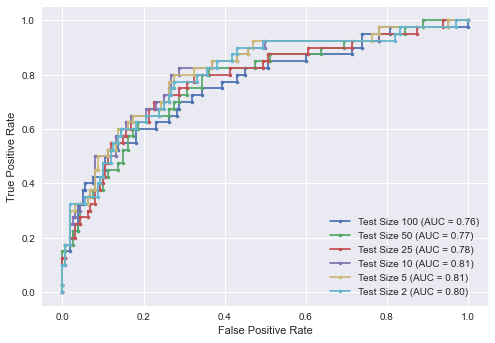

In [246]:
# Split into X, y and encode categorical features
X, y = X_y_split(df=data200_df, target='Pathologic?', to_numpy=False)
X = encodeCategories(X)
print(f'-----------------------------------------------\n')

# Implement k-fold cross-validation with logistic regression classifier for multiple sizes of k
k_sizes = [2, 4, 8, 20, 40, 100]
for k in k_sizes:
    
    # Stratified k-fold cross-validation of Logistic Regression model
    y_true, y_pred, y_score = kFold_logReg_classification(X=X.to_numpy(), y=y.to_numpy(), k_fold=k)
    
    # Evaluate performance
    logReg_performance_eval(y_true=y_true, y_pred=y_pred, y_score=y_score, roc_label=f'Test Size {int(200/k)}')
    print(f'------------------------------------------------------------\n')
    